In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import pickle
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [317]:
with open('/content/drive/MyDrive/Colab Notebooks/FYP/Scalers/gkp_scaler.pkl', 'rb') as f:
  scaler_GKP = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/FYP/Scalers/def_scaler.pkl', 'rb') as f:
  scaler_DEF = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/FYP/Scalers/mid_scaler.pkl', 'rb') as f:
  scaler_MID = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/FYP/Scalers/fwd_scaler.pkl', 'rb') as f:
  scaler_FWD = pickle.load(f)

In [318]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FYP/Generated Datasets/End of Season/train_test_dataset.csv')
df.head()

,season_x,element,name,position,GW,gw_points,was_home,minutes,minutes_per_gameweek,prev_game_minutes_1,...,previous_season_yellow_cards_per_game,previous_season_red_cards_per_game,opp_team_goals_scored_per_game,opp_team_xG_per_game,opp_team_goals_conceded_per_game,opp_team_xGA_per_game,opp_team_goals_scored_form,opp_team_goals_conceded_form,opp_team_goalless_games_per_game,opp_team_clean_sheets_per_game
0,2017-18,443,Aaron Cresswell,DEF,1,0,0,9,0.00,0.0,...,0.076923,0.038462,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
1,2017-18,443,Aaron Cresswell,DEF,2,1,0,90,9.00,9.0,...,0.076923,0.038462,0.000000,2.000000,0.0,0.300000,0.000000,0.0,1.000000,1.0
2,2017-18,443,Aaron Cresswell,DEF,3,1,0,90,49.50,90.0,...,0.076923,0.038462,0.000000,0.750000,1.5,1.400000,0.000000,1.5,1.000000,0.0
3,2017-18,443,Aaron Cresswell,DEF,4,6,1,90,63.00,90.0,...,0.076923,0.038462,1.333333,1.066667,0.0,0.833333,1.333333,0.0,0.333333,1.0
4,2017-18,443,Aaron Cresswell,DEF,5,9,0,90,69.75,90.0,...,0.076923,0.038462,1.000000,1.000000,1.0,0.875000,1.000000,1.0,0.000000,0.5


In [319]:
def make_gw(df, gw):
  df = df.loc[(df['season_x'] == '2023-24') & (df['GW'] == gw)]

  # Splitting df by Position

  df_GKP = df[df.position == 'GKP']
  df_DEF = df[df.position == 'DEF']
  df_MID = df[df.position == 'MID']
  df_FWD = df[df.position == 'FWD']

  # Storing Player Names in an Array

  elements_GKP = np.array(df_GKP['element'])
  elements_DEF = np.array(df_DEF['element'])
  elements_MID = np.array(df_MID['element'])
  elements_FWD = np.array(df_FWD['element'])

  names_GKP = np.array(df_GKP['name'])
  names_DEF = np.array(df_DEF['name'])
  names_MID = np.array(df_MID['name'])
  names_FWD = np.array(df_FWD['name'])

  points_GKP = np.array(df_GKP['gw_points'])
  points_DEF = np.array(df_DEF['gw_points'])
  points_MID = np.array(df_MID['gw_points'])
  points_FWD = np.array(df_FWD['gw_points'])

  # Removing Unwanted Fields

  df_GKP.drop(['season_x', 'minutes', 'gw_points', 'element', 'name', 'position'], axis=1, inplace=True)
  df_DEF.drop(['season_x', 'minutes', 'gw_points', 'element', 'name', 'position', 'saves_per_game', 'previous_season_saves_per_game'], axis=1, inplace=True)
  df_MID.drop(['season_x', 'minutes', 'gw_points', 'element', 'name', 'position', 'saves_per_game', 'previous_season_saves_per_game'], axis=1, inplace=True)
  df_FWD.drop(['season_x', 'minutes', 'gw_points', 'element', 'name', 'position', 'saves_per_game', 'previous_season_saves_per_game', 'clean_sheets_per_game', 'previous_season_clean_sheets_per_game'], axis=1, inplace=True)

  # Normalisation

  df_GKP = scaler_GKP.transform(df_GKP)
  df_DEF = scaler_DEF.transform(df_DEF)
  df_MID = scaler_MID.transform(df_MID)
  df_FWD = scaler_FWD.transform(df_FWD)

  return df, elements_GKP, elements_DEF, elements_MID, elements_FWD, names_GKP, names_DEF, names_MID, names_FWD, df_GKP, points_GKP, points_DEF, points_MID, points_FWD, df_DEF, df_MID, df_FWD

In [320]:
def predict_GKP():
  GKP = pd.DataFrame()

  pred_GKP = dt_GKP.predict(df_GKP)

  GKP.insert(loc=0, column='gw_points', value=points_GKP)
  GKP.insert(loc=0, column='predicted_points', value=pred_GKP)
  GKP.insert(loc=0, column='position', value='GKP')
  GKP.insert(loc=0, column='name', value=names_GKP)
  GKP.insert(loc=0, column='element', value=elements_GKP)
  GKP['value'] = None

  for index, row in GKP.iterrows():
    element = row['element']
    url = 'https://fantasy.premierleague.com/api/element-summary/' + str(element) + '/'

    response = requests.get(url)

    if response.status_code == 200:
      data = response.json()

      value = data['history'][15]['value']

      GKP.loc[index, 'value'] = value

    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")

  GKP = GKP.groupby('element').agg({'name': 'first', 'position': 'first', 'predicted_points': 'sum', 'value': 'first', 'gw_points': 'first'}).reset_index()

  return GKP

In [321]:
def predict_DEF():
  DEF = pd.DataFrame()

  pred_DEF = rf_DEF.predict(df_DEF)

  DEF.insert(loc=0, column='gw_points', value=points_DEF)
  DEF.insert(loc=0, column='predicted_points', value=pred_DEF)
  DEF.insert(loc=0, column='position', value='DEF')
  DEF.insert(loc=0, column='name', value=names_DEF)
  DEF.insert(loc=0, column='element', value=elements_DEF)
  DEF['value'] = None

  for index, row in DEF.iterrows():
    element = row['element']
    url = 'https://fantasy.premierleague.com/api/element-summary/' + str(element) + '/'

    response = requests.get(url)

    if response.status_code == 200:
      data = response.json()

      value = data['history'][15]['value']

      DEF.loc[index, 'value'] = value

    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")

  DEF = DEF.groupby('element').agg({'name': 'first', 'position': 'first', 'predicted_points': 'sum', 'value': 'first', 'gw_points': 'first'}).reset_index()

  return DEF

In [322]:
def predict_MID():
  MID = pd.DataFrame()

  pred_MID = rf_MID.predict(df_MID)

  MID.insert(loc=0, column='gw_points', value=points_MID)
  MID.insert(loc=0, column='predicted_points', value=pred_MID)
  MID.insert(loc=0, column='position', value='MID')
  MID.insert(loc=0, column='name', value=names_MID)
  MID.insert(loc=0, column='element', value=elements_MID)
  MID['value'] = None

  for index, row in MID.iterrows():
    element = row['element']
    url = 'https://fantasy.premierleague.com/api/element-summary/' + str(element) + '/'

    response = requests.get(url)

    if response.status_code == 200:
      data = response.json()

      value = data['history'][15]['value']

      MID.loc[index, 'value'] = value

    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")

  MID = MID.groupby('element').agg({'name': 'first', 'position': 'first', 'predicted_points': 'sum', 'value': 'first', 'gw_points': 'first'}).reset_index()

  return MID

In [323]:
def predict_FWD():
  FWD = pd.DataFrame()

  pred_FWD = gb_FWD.predict(df_FWD)

  FWD.insert(loc=0, column='gw_points', value=points_FWD)
  FWD.insert(loc=0, column='predicted_points', value=pred_FWD)
  FWD.insert(loc=0, column='position', value='FWD')
  FWD.insert(loc=0, column='name', value=names_FWD)
  FWD.insert(loc=0, column='element', value=elements_FWD)
  FWD['value'] = None

  for index, row in FWD.iterrows():
    element = row['element']
    url = 'https://fantasy.premierleague.com/api/element-summary/' + str(element) + '/'

    response = requests.get(url)

    if response.status_code == 200:
      data = response.json()

      value = data['history'][15]['value']

      FWD.loc[index, 'value'] = value

    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")

  FWD = FWD.groupby('element').agg({'name': 'first', 'position': 'first', 'predicted_points': 'sum', 'value': 'first', 'gw_points': 'first'}).reset_index()

  return FWD

### Loading Models

In [324]:
with open('/content/drive/MyDrive/Colab Notebooks/FYP/Saved Models/DT/dt_GKP.pkl', 'rb') as file:
    dt_GKP = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/FYP/Saved Models/RF/rf_DEF.pkl', 'rb') as file:
    rf_DEF = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/FYP/Saved Models/RF/rf_MID.pkl', 'rb') as file:
    rf_MID = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/FYP/Saved Models/GB/gb_FWD.pkl', 'rb') as file:
    gb_FWD = pickle.load(file)

## Predicting

In [325]:
df, elements_GKP, elements_DEF, elements_MID, elements_FWD, names_GKP, names_DEF, names_MID, names_FWD, df_GKP, points_GKP, points_DEF, points_MID, points_FWD, df_DEF, df_MID, df_FWD = make_gw(df, 15)

<ipython-input-319-c39e31872876>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GKP.drop(['season_x', 'minutes', 'gw_points', 'element', 'name', 'position'], axis=1, inplace=True)
<ipython-input-319-c39e31872876>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DEF.drop(['season_x', 'minutes', 'gw_points', 'element', 'name', 'position', 'saves_per_game', 'previous_season_saves_per_game'], axis=1, inplace=True)
<ipython-input-319-c39e31872876>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [326]:
GKP = predict_GKP()
DEF = predict_DEF()
MID = predict_MID()
FWD = predict_FWD()

In [327]:
df = pd.concat([GKP, DEF, MID, FWD], ignore_index=True)

In [265]:
prev_gw_team = df[
    (df['element'] == 230) | (df['element'] == 28) | # GKPs
    (df['element'] == 206) | (df['element'] == 290) | (df['element'] == 131) | (df['element'] == 616) | (df['element'] == 197) | # DEFs
    (df['element'] == 108) | (df['element'] == 26) | (df['element'] == 516) | (df['element'] == 501) | (df['element'] == 19) | # MIDs
    (df['element'] == 225) | (df['element'] == 355) | (df['element'] == 326) # FWDs
    ]

len(prev_gw_team)

15

In [266]:
prev_gw_team

,element,name,position,predicted_points,value,gw_points
2,28,Matt Turner,GKP,0.236207,40,3
27,230,Sam Johnstone,GKP,3.332192,47,2
124,131,Pervis Estupinan,DEF,0.621879,50,0
146,197,Levi Colwill,DEF,2.201892,45,1
151,206,Reece James,DEF,1.744419,54,1
177,290,Trent Alexander-Arnold,DEF,4.370018,81,4
292,616,Josko Gvardiol,DEF,2.485883,49,2
341,19,Bukayo Saka,MID,4.054244,89,2
344,26,Leandro Trossard,MID,3.151396,65,1
383,108,Bryan Mbeumo,MID,4.209217,70,0


In [267]:
prev_gw_team['value'].sum()

1003

#### Adding Player with Highest Predicted

In [328]:
df.sort_values('predicted_points', ascending=False).head(20)

,element,name,position,predicted_points,value,gw_points
465,308,Mohamed Salah,MID,5.726196,131,3
341,19,Bukayo Saka,MID,5.342384,89,5
709,355,Erling Haaland,FWD,5.105730,140,2
337,12,Gabriel Martinelli Silva,MID,4.767104,78,7
338,14,Martin Odegaard,MID,4.716665,83,5
344,26,Leandro Trossard,MID,4.600981,65,1
177,290,Trent Alexander-Arnold,DEF,4.459348,81,12
553,516,Son Heung-min,MID,4.402718,96,2
32,275,Bernd Leno,GKP,4.279461,47,6
494,373,Bruno Borges Fernandes,MID,4.151550,83,0


In [270]:
df_filtered = df[df['element'] == 211]

gw_team = pd.concat([prev_gw_team, df_filtered], ignore_index=True)

#### Removing Player with Least Predicted

In [271]:
prev_gw_team_filtered = prev_gw_team[prev_gw_team['position'] == 'DEF']
prev_gw_team_filtered.sort_values('predicted_points', ascending=True).head()

,element,name,position,predicted_points,value,gw_points
124,131,Pervis Estupinan,DEF,0.621879,50,0
151,206,Reece James,DEF,1.744419,54,1
146,197,Levi Colwill,DEF,2.201892,45,1
292,616,Josko Gvardiol,DEF,2.485883,49,2
177,290,Trent Alexander-Arnold,DEF,4.370018,81,4


In [272]:
to_drop_indices = gw_team[gw_team['element'] == 355].index

gw_team = gw_team.drop(to_drop_indices)

In [273]:
gw_team['value'].sum()

932

#### Lineup

In [274]:
gw_team.sort_values(by='predicted_points', ascending=False)

,element,name,position,predicted_points,value,gw_points
5,290,Trent Alexander-Arnold,DEF,4.370018,81,4
9,108,Bryan Mbeumo,MID,4.209217,70,0
7,19,Bukayo Saka,MID,4.054244,89,2
15,211,Nicolas Jackson,FWD,3.736177,69,1
11,516,Son Heung-min,MID,3.697456,96,17
10,501,Dejan Kulusevski,MID,3.655404,70,2
1,230,Sam Johnstone,GKP,3.332192,47,2
12,225,Odsonne Edouard,FWD,3.302792,55,1
8,26,Leandro Trossard,MID,3.151396,65,1
6,616,Josko Gvardiol,DEF,2.485883,49,2


## Graph

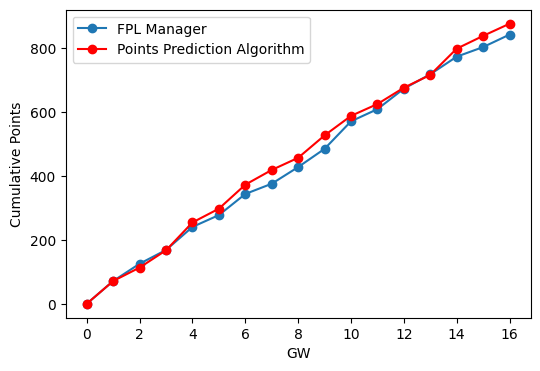

In [276]:
gw_points = [0, 71, 54, 43, 72, 37, 66, 32, 52, 57, 86, 38, 64, 45, 55, 30, 39, ]
gw_points_algorithm = [0, 71, 42, 54, 87, 43, 75, 46, 38, 70, 61, 37, 51, 40, 82, 40, 38, ]

cumulative_gw_points = [sum(gw_points[:i+1]) for i in range(len(gw_points))]
cumulative_gw_points_algorithm= [sum(gw_points_algorithm[:i+1]) for i in range(len(gw_points_algorithm))]

plt.figure(figsize=(6, 4))
plt.plot(range(len(cumulative_gw_points)), cumulative_gw_points, marker='o', label='FPL Manager')

plt.plot(range(len(cumulative_gw_points_algorithm)), cumulative_gw_points_algorithm, marker='o', color='red', label='Points Prediction Algorithm')

plt.xlabel('GW')
plt.ylabel('Cumulative Points')
plt.legend()

plt.show()